In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the CSV file 
df = pd.read_csv("diabetes.csv") 

# Set the display setting so that oclumns are shown across the screen and not truncated
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

# Review the features to see what they look like and to check distributions
print(df.shape)
print(df.head(10))
print(df.describe().T)
print(df.info)

 # Review the data types of each feature. All are floats! 
df.columns.to_list()
print("The datatypes are:\n", df.dtypes)

# Reviewing the unique values 
print("The number of unique values is:\n",df.nunique().sort_values())

# Reviewing the level of null values
print("The level of null values is:\n", df.isnull().sum())

# show all of the columns in diabetes with associated unique values
for column in df.columns:
    print(f"\ncolumn: {column}")
    print(sorted(df[column].unique()))

# Check for missing values. There are no missing or unusual values! This dataset is remarkably clean!
df.isna().sum().sort_values(ascending=False)

# EDA
# We will look at the distrubutions of all variables (as all are floats)
# Plot the data using bar charts 
for col in df.columns:
    plt.figure(figsize=(6,4))

    # If the column is binary or categorical (few unique values)
    if df[col].nunique() <= 10:
        sns.countplot(data=df, x=col)
        plt.title(f"Countplot for {col}")
    
    # If the column is numeric with many unique values
    else:
        sns.histplot(data=df, x=col, bins=30, kde=False)
        plt.title(f"Histogram for {col}")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Some of the features could be banded e.g. 
# BMI could be banded into 1: Underweight, 2: Normal weight, 3: Overweight, 4: Obese 
# 

# 1. BMI_Category
# 1     31273  
# 2    68953 
# 3    93749
# 4    87851

# Define the conditions for BMI categories
conditions = [
    df["BMI"] <= 18.5,  # Underweight
    (df["BMI"] > 18.5) & (df["BMI"] <= 24.8),  # Normal Weight
    (df["BMI"] >= 25) & (df["BMI"] <= 29.9),  # Overweight
    df["BMI"] >= 30  # Obese
]

values = ["Underweight", "Normal Weight", "Overweight", "Obese"]

# Apply np.select to categorize BMI
df["BMI_Category"] = np.select(conditions, values, default="Unknown")

# Display the value counts of the BMI categories
print(df["BMI_Category"].value_counts())



## Correlations: Need to specigy Correlations as Spearman as distribution are skewed/not normally distributed 
# 1. Correlation. Firstly do a full correlation of all features vs all features
df_numeric1 = df.select_dtypes(include=[np.number])
corr1 = df_numeric1.corr(method="spearman")
print(corr1)

plt.figure(figsize=(12, 9))
sns.heatmap(
    corr1,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)


plt.title("Correlation Matrix", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Initital dataset saved to CSV format for review and analysis
df.to_csv("diabetes_cleaned.csv", index=False)


# 2. Correlation. Next do a corrrelation where the target is Diabetes_012
df_numeric2 = df.select_dtypes(include=[np.number])
corr2 = df_numeric2.corr(method="spearman")["Diabetes_012"].sort_values(ascending=False)
print(corr2)

# convert to datafrmae for heatmap!
corr_df=corr2.to_frame()
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix  against Diabetes_012", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Correlation summary: There are not that many strong correlations with Diabetes_012. GenHlth is the best one:
# Diabetes_012            1.000000
# GenHlth                 0.297138 - Worse general health, higher
# HighBP                  0.271668
# BMI                     0.235887
# DiffWalk                0.223567
# HighChol                0.210668
# Age                     0.186357
# HeartDiseaseorAttack    0.178564
# PhysHlth                0.161718
# Stroke                  0.105887
# CholCheck               0.068018
# Smoker                  0.063040
# MentHlth                0.044921
# NoDocbcCost             0.037379
# Sex                     0.030143
# AnyHealthcare           0.014530
# Fruits                 -0.042268
# HvyAlcoholConsump      -0.057244
# Veggies                -0.059353
# PhysActivity           -0.121988
# Education              -0.126862
# Income                 -0.172611





In [ ]:
# --- Kruskal-Wallis (separate cell) --- Generated by the AI Assistant
from scipy.stats import kruskal

# Map BMI_Category to an ordinal code (if not already present)
bmi_order = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
bmi_map = {k: i+1 for i, k in enumerate(bmi_order)}
if 'BMI_Category' in df.columns:
    df['BMI_Category_Code'] = df['BMI_Category'].map(bmi_map)
else:
    # fallback: create BMI_Category then map
    conditions = [
        df['BMI'] <= 18.5,
        (df['BMI'] > 18.5) & (df['BMI'] <= 24.8),
        (df['BMI'] >= 25) & (df['BMI'] <= 29.9),
        df['BMI'] >= 30,
    ]
    values = ['Underweight', 'Normal Weight', 'Overweight', 'Obese']
    df['BMI_Category'] = np.select(conditions, values, default=np.nan)
    df['BMI_Category_Code'] = df['BMI_Category'].map(bmi_map)

vars_to_test = ['GenHlth', 'BMI', 'BMI_Category_Code']
alpha = 0.05
labels = sorted(df['Diabetes_012'].dropna().unique())

for var in vars_to_test:
    groups = [df.loc[df['Diabetes_012'] == g, var].dropna() for g in labels]
    non_empty = [grp for grp in groups if len(grp) > 0]
    if len(non_empty) < 2:
        print(f"Not enough non-empty groups for {var} - skipping")
        continue
    stat, p = kruskal(*non_empty)
    medians = {int(lbl): df.loc[df['Diabetes_012']==lbl, var].median() for lbl in labels}
    sig = 'reject H0' if p < alpha else 'fail to reject H0'
    print(f"{var}: H={stat:.4f}, p={p:.4e} -> {sig}; medians={medians}")

# Visualise with boxplots
for var in vars_to_test:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Diabetes_012', y=var, data=df)
    plt.title(f"Boxplot of {var} by Diabetes_012")
    plt.tight_layout()
    plt.show()
    
# Results Summary: 
# GenHlth: People without diabetes report a median general health of 2 (“Very Good”), whilst people with prediabetes and diabetes 
# report a median of 3 (“Good”).
# Findings: General health declines across diabetes groups. Individuals without diabetes typically report “Very Good” health, whereas 
# those with prediabetes or diabetes report “Good” health. The difference is statistically significant (p < 0.001).

# BMI: People without diabetes report a lower BMI of median 27.0 (range=Overweight), whilst people with prediabetes and diabetes report
# a median of 30.0 and 31.0 respectively (Range=Obese).
# Findings: BMI increases steadily across diabetes groups. Individuals without diabetes typically fall in the Overwight range, whereas 
# those with prediabetes or diabetes fall in the Obese range. The difference is statistically significant (p < 0.001) reinforcing the 
# strong assocaition between higher BMIand diabetes severity.

In [ ]:
# Chi Sqaure for all of the binary variables. What matters is the Cramers_V score.
# Results Summary: 
# Strongest predictors
# HighBP (V=0.272): Moderate, clincially meaningful
# DiffWalk (V=0.224): Moderate, clincially meaningful
# HighChol (V=0.211): Moderate, clincially meaningful

# Weaker but still relevant predictors
# HeartDiseaseAttack(V=0.180): Weak but still clinically meaningful
# PhysActivity (V=0.122): Weak but still clinically meaningful
# Stroke (V=0.107): Weak but still clinically meaningful

# Findings to date: 
# The strongest predicotrs of diabetes are High Blood Presssure, High cholesterol, High BMI/Obesity, poorer general health. mobility ddifficulty and older age.

# Moderator predictors are heart disease, physical inactivity and stroke

# Weak predictors are: smoking, diet (fruit/vegetables), alcohol, sex and education  

# Logistic Regression


In [ ]:
# Chi-square tests for specified binary variables vs Diabetes_012 — combined summary table
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd

binary_vars = [
    'HighBP',
    'HighChol',
    'Stroke',
    'HeartDiseaseorAttack',
    'PhysActivity',
    'Smoker',
    'Fruits',
    'Veggies',
    'HvyAlcoholConsump',
    'Sex',
    'DiffWalk',
    'NoDocbcCost'
 ]
labels = sorted(df['Diabetes_012'].dropna().unique())

def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    if n == 0 or min(r-1, k-1) == 0:
        return np.nan
    return np.sqrt(chi2 / (n * min(r-1, k-1)))

results = []
print('Computing chi-square and Cramer\'s V for binary variables vs Diabetes_012...\n')
for var in binary_vars:
    if var not in df.columns:
        print(f"{var}: NOT IN DATA -- skipping\n")
        continue
    ct = pd.crosstab(df[var], df['Diabetes_012'])
    if ct.size == 0:
        print(f"{var}: empty crosstab -- skipping\n")
        continue
    try:
        chi2, p, dof, expected = chi2_contingency(ct)
        cv = cramers_v(ct)
        # counts of 'positive' (value==1) per Diabetes_012 group when applicable
        row = {'variable': var, 'chi2': chi2, 'p': p, 'dof': dof, 'cramers_v': cv}
        is_binary_one = df[var].isin([1]).any()
        for lbl in labels:
            col_name = f'pos_count_{int(lbl)}'
            if is_binary_one:
                cnt = int(df.loc[(df[var] == 1) & (df['Diabetes_012'] == lbl)].shape[0])
            else:
                cnt = np.nan
            row[col_name] = cnt
        results.append(row)
    except Exception as e:
        print(f"Error testing {var}: {e}\n")

# Build summary dataframe
if results:
    res_df = pd.DataFrame(results)
    # ensure pos_count columns appear in order 0,1,2 if present
    pos_cols = [c for c in res_df.columns if c.startswith('pos_count_')]
    ordered_cols = ['variable', 'chi2', 'p', 'dof', 'cramers_v'] + sorted(pos_cols)
    res_df = res_df[ordered_cols]
    res_df = res_df.sort_values('cramers_v', ascending=False).reset_index(drop=True)
    print('Summary table (sorted by Cramer\'s V):')
    display(res_df)
else:
    print('No results to display')

# Time for Modelling: Logistic Regression First - using AI Agent and modified by the data analyst

In [ ]:
# Logistic regression using AI Agent and some minor tweaks!
# Findings Summary: 
# Accuracy: 0.8471
# Classification report:
# Precision = Of all the cases the model said werre diabestes, how many were truly diabetes (i.e. few false positives)
# recall = Of all the people who actually have diabetes, how many did the model correctly identify? (i.e. few false negatives)
# f1_score: = How well does the model perform when we care about both catching true cases and avoiding false alarms? 
# Support = How many real examples of this class were in the data?
# Class 0: no diabetes
# Class 1: prediabetes
# Class 2: diabetes

#              precision    recall  f1-score   support

#           0     0.8636    0.9748    0.9158     42741
#           1     0.0000    0.0000    0.0000       926
#           2     0.5285    0.1862    0.2753      7069
# Logistic regression has a good accuracy level and is good for predicting pre-diabetes but struggles to separte the diabetes classes. So RnadomForest is now needed.
# The same variables show up as strong predictors:
# HighBP
# HIghChol
# BMI
# GenHlth
# DiffWalk
# Age

# Use numeric features only (drop target)
X = df.select_dtypes(include=[np.number]).copy()
if 'Diabetes_012' in X.columns:
    X = X.drop(columns=['Diabetes_012'])
y = df['Diabetes_012'].astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Fit One-vs-Rest logistic regression
base = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(base)
clf.fit(X_train_s, y_train)
y_pred = clf.predict(X_test_s)

# Metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - One-vs-Rest Logistic Regression')
plt.tight_layout()
plt.show()

# Coefficients: assemble per-class coefficients from estimators_
coef_mat = np.vstack([est.coef_.ravel() for est in clf.estimators_])  # shape (n_classes, n_features)
coef_df = pd.DataFrame(coef_mat.T, index=X.columns, columns=[f'class_{c}' for c in clf.classes_])
print('\nTop positive/negative coefficients per class:')
for c in coef_df.columns:
    top_pos = coef_df[c].sort_values(ascending=False).head(8)
    top_neg = coef_df[c].sort_values().head(8)
    print(f"\n{c} - top positive features:\n", top_pos)
    print(f"{c} - top negative features:\n", top_neg)
    
# 

In [ ]:
# Random Forest using AI Agent with some minor tweaks
# Result Sunmarry:
# Accuracy: 0.8383396404919584

# Classification report:
#              precision    recall  f1-score   support

#           0     0.8593    0.9688    0.9108     42741
#           1     0.0000    0.0000    0.0000       926
#           2     0.4682    0.1591    0.2375      7069

# # Random Forest has a good accuracy level and is good for predicting peple without diabetes but like logistic regression struggles 
# to separate the diabetes classes. 
# TOnce agin he same variables show up as strong predictors:
# Top 15 feature importances:
# BMI                  0.143816
# Age                  0.136396
# Income               0.100145
# PhysHlth             0.078207
# GenHlth              0.071546
# Education            0.070318
# MentHlth             0.065394
# Smoker               0.035637
# Fruits               0.035636
# Sex                  0.034450
# HighBP               0.034131
# PhysActivity         0.028288
# HighChol             0.028200
# Veggies              0.027919
# BMI_Category_Code    0.024494
# 
# Overall Summary: Random Forest feature importance identified BMI, age, income, physical health, and general health as the strongest 
# predictors of diabetes. These findings align closely with the earlier correlation, Chi‑Square, and logistic regression analyses. 
# Behavioral and lifestyle factors such as smoking, physical activity, and fruit/vegetable intake contributed modestly, 
# while demographic variables such as sex showed only weak predictive value. 
# 
# Summary Overall: Biological and functional health indicators were far more influential than lifestyle factors in predicting diabetes status.

In [ ]:
# Random Forest classifier (multiclass) — train / evaluate / importances
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Prepare features and target (same preprocessing as used previously)
X = df.select_dtypes(include=["number"]).drop(columns=["Diabetes_012"]).copy()
y = df["Diabetes_012"].astype(int)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# RandomForest — no scaling required, handle imbalance with class_weight
rf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importances
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 15 feature importances:\n", fi.head(15))

# Optional: plot the top importances
plt.figure(figsize=(8,6))
fi.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 RandomForest feature importances')
plt.tight_layout()
plt.show()


In [ ]:
# Smote + Class_weight using the AI Agent with minor tweaks


Loading data...
Class distribution (original): Counter({0: 213703, 2: 35346, 1: 4631})
Class distribution (train before SMOTE): Counter({0: 170962, 2: 28277, 1: 3705})
SMOTE sampling_strategy: {2: 170962, 1: 170962}
Class distribution (train after SMOTE): Counter({0: 170962, 2: 170962, 1: 170962})
Training RandomForest (n_estimators=150, max_depth=12, n_jobs=1)...

Accuracy: 0.8168

Classification report:
               precision    recall  f1-score   support

           0     0.8964    0.8927    0.8945     42741
           1     0.0000    0.0000    0.0000       926
           2     0.4026    0.4651    0.4316      7069

    accuracy                         0.8168     50736
   macro avg     0.4330    0.4526    0.4420     50736
weighted avg     0.8112    0.8168    0.8137     50736


Confusion matrix:
 [[38153     3  4585]
 [  632     0   294]
 [ 3778     3  3288]]

Saved feature importances to rf_smote_feature_importances.csv
Saved feature importances plot to rf_smote_feature_importances

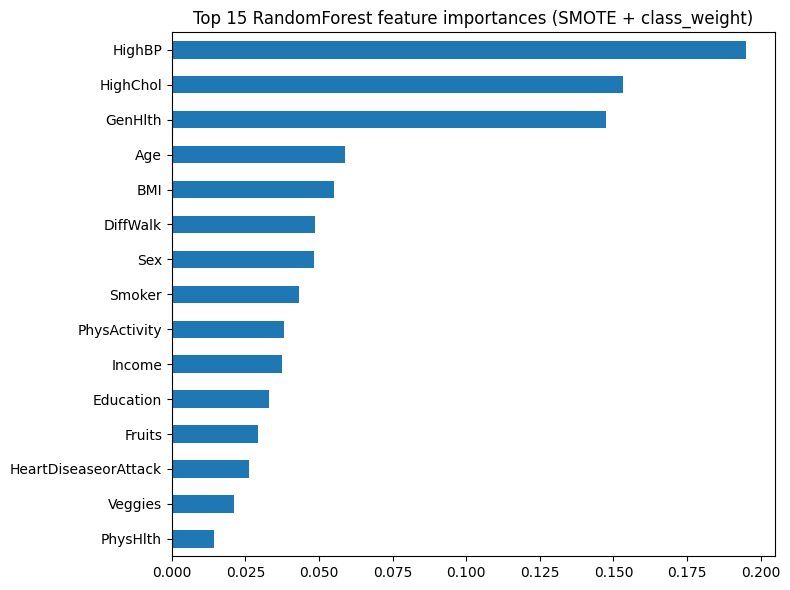

In [32]:
#!/usr/bin/env python3
# Run RandomForest with SMOTE oversampling...

import sys
import subprocess
import os
from collections import Counter

try:
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    import matplotlib.pyplot as plt
except Exception as e:
    print("Missing packages:", e)
    sys.exit(1)

# Ensure imbalanced-learn (SMOTE) is available
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    print("imbalanced-learn not found, installing it now (may take a moment)...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"]) 
    from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42
DATA_PATH = "diabetes.csv"

if not os.path.exists(DATA_PATH):
    print(f"Data file {DATA_PATH} not found in {os.getcwd()}")
    sys.exit(1)

print("Loading data...")
df = pd.read_csv(DATA_PATH)

# Prepare features and target (numeric features only)
X = df.select_dtypes(include=["number"]).copy()
if "Diabetes_012" not in X.columns:
    raise SystemExit("Target column 'Diabetes_012' not present in data")

X = X.drop(columns=["Diabetes_012"]) 
y = df["Diabetes_012"].astype(int)

print("Class distribution (original):", Counter(y))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print("Class distribution (train before SMOTE):", Counter(y_train))

# Apply SMOTE to training data (multiclass)
# To avoid exploding memory usage, upsample minority classes only up to a fraction
# of the majority class (instead of full parity). Compute a sensible target.
train_counts = Counter(y_train)
major_label, major_count = train_counts.most_common(1)[0]
target_count = max( int(major_count // 2), max(train_counts.values()) )
sampling_strategy = {}
for lbl, cnt in train_counts.items():
    if lbl == major_label:
        continue
    # upsample minority classes to target_count (no more than majority)
    sampling_strategy[int(lbl)] = min(target_count, major_count)

print("SMOTE sampling_strategy:", sampling_strategy)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=RANDOM_STATE)
X_res, y_res = smote.fit_resample(X_train, y_train)
print("Class distribution (train after SMOTE):", Counter(y_res))

# Train RandomForest with class_weight='balanced'. Reduce size and parallelism to save memory.
rf = RandomForestClassifier(n_estimators=150, max_depth=12, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1)
print("Training RandomForest (n_estimators=150, max_depth=12, n_jobs=1)...")
try:
    rf.fit(X_res, y_res)
except MemoryError:
    print("MemoryError while training RandomForest; retrying with smaller model...")
    rf = RandomForestClassifier(n_estimators=80, max_depth=8, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=1)
    rf.fit(X_res.sample(n=min(200000, X_res.shape[0]), random_state=RANDOM_STATE),
           y_res.sample(n=min(200000, len(y_res)), random_state=RANDOM_STATE))

# Predict on test set
y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importances -> save
fi = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
out_csv = "rf_smote_feature_importances.csv"
fi.to_csv(out_csv, header=["importance"] )
print(f"\nSaved feature importances to {out_csv}")

# Plot top 15
plt.figure(figsize=(8,6))
fi.head(15).sort_values().plot(kind='barh')
plt.title('Top 15 RandomForest feature importances (SMOTE + class_weight)')
plt.tight_layout()
out_png = 'rf_smote_feature_importances.png'
plt.savefig(out_png, dpi=150)
print(f"Saved feature importances plot to {out_png}")

print('\nDone.')
plt.show()
